In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem:
the results obtained from using the new data structure (moelculepairopt) are different from previous results

In [100]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [101]:
import dill
from src.train_utils import TrainUtils
from src.config import Config
from matchms.importing import load_from_mgf
import numpy as np
from tqdm import tqdm
from src.spec2vec_comparison import Spec2VecComparison
from matchms.filtering import add_fingerprint
from scipy.stats import spearmanr
from src.plotting import Plotting
from src.loader_saver import LoaderSaver

In [102]:
config=Config()

In [103]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file = data_folder + 'drug_plus.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl'

In [104]:
THRESHOLD_ANALOG=0.7

##Get data

In [105]:
all_spectrums_janssen_MATCHMS = [(s) for s in load_from_mgf(janssen_path)]

2024-03-18 16:02:56,467:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,468:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,469:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,470:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,470:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,471:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,472:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,473:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,473:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,474:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,475:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 16:02:56,475:WARNING:matchms:add

In [106]:
len(all_spectrums_janssen_MATCHMS)

2546

In [107]:
all_spectrums_MATCHMS =  all_spectrums_janssen_MATCHMS 

In [108]:
#compute all the hashes from the datasets
target_hashes = [s.spectrum_hash() for s in all_spectrums_MATCHMS]

In [109]:
spectrums_0 = [s.spectrum_object_0 for s in original_molecule_pairs]
spectrums_1 =[s.spectrum_object_1 for s in original_molecule_pairs]

In [110]:
unique_hashes_in_molecule_pairs= np.unique([s.spectrum_hash for s in spectrums_0]+\
                                           [s.spectrum_hash for s in spectrums_1])

In [111]:
# spectrums that are used in my dataset
spectrums_match_hash= [(s,t) for s,t in zip(all_spectrums_MATCHMS, target_hashes) if (t in unique_hashes_in_molecule_pairs)]

In [112]:
original_spectrum_match_hash= [p[0] for p in spectrums_match_hash]
target_hashes_subset = [p[1] for p in spectrums_match_hash]

In [113]:
for i in tqdm(range(len(original_spectrum_match_hash))):
    original_spectrum_match_hash[i] = add_fingerprint(original_spectrum_match_hash[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2033/2033 [00:04<00:00, 485.53it/s]


In [114]:
preprocessed_spectrums = original_spectrum_match_hash.copy()

In [115]:
for i in tqdm(range(len(original_spectrum_match_hash))):
    preprocessed_spectrums[i] = Spec2VecComparison.spectrum_processing(original_spectrum_match_hash[i])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2033/2033 [00:03<00:00, 584.41it/s]


In [116]:
for i in tqdm(range(len(preprocessed_spectrums))):
    preprocessed_spectrums[i] = add_fingerprint(preprocessed_spectrums[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2033/2033 [00:04<00:00, 489.15it/s]


In [117]:
loader_saver = LoaderSaver(
        block_size=100,
        pickle_nist_path='',
        pickle_gnps_path='',
        pickle_janssen_path=output_janssen_file,
    )

In [118]:
all_spectrums_janssen = loader_saver.get_all_spectrums(
            janssen_path,
            100000000,
            use_tqdm=True,
            use_nist=False,
            config=config,
            use_janssen=True,
        )

  0%|                                                                                                                                                                  | 2033/100000000 [00:00<9:38:31, 2880.80it/s]


We reached the end of the array at index 2033


In [119]:
len(all_spectrums_janssen)

2033

In [120]:
#spectrums_janssen = [s for s in original_molecule_pairs.spectrums if s.library=='janssen']
number_pairs=100000
original_molecule_pairs= TrainUtils.compute_all_tanimoto_results(all_spectrums_janssen, 
                                                                max_combinations=number_pairs, 
                                                                use_tqdm=True, 
                                                                max_mass_diff=config.MAX_MASS_DIFF, 
                                                                min_mass_diff=config.MIN_MASS_DIFF)

Starting computation of molecule pairs
2024-03-18 16:03:11.023730
Computing all the tanimoto results


Processing:   0%|                                                                                                                                                                        | 0/100000 [00:00<?, ?it/s]

Compute all the fingerprints
Number of workers: 15
Precomputing min and max index



2033it [00:00, 28105.43it/s]
Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:15<00:00, 6591.81it/s]

Number of effective pairs originally computed: 100000 
Number of effective pairs retrieved: 68360 
2024-03-18 16:03:26.273969


In [121]:
original_molecule_pairs

In [122]:
from src.modified_cosine import ModCosine

In [123]:
modcos_similarity =ModCosine.get_mod_cosine()

In [124]:
tanimoto_modcos, scores_modcos= ModCosine.compute_scores_tanimoto(original_molecule_pairs, 
                                                                                preprocessed_spectrums, 
                                                                               target_hashes_subset, 
                                                                               modcos_similarity)

  1%|█▉                                                                                                                                                                       | 805/68360 [00:00<00:08, 8043.49it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

  3%|█████▊                                                                                                                                                                  | 2355/68360 [00:00<00:09, 7063.12it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

  6%|█████████▎                                                                                                                                                              | 3776/68360 [00:00<00:09, 6981.23it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

  8%|████████████▊                                                                                                                                                           | 5208/68360 [00:00<00:08, 7084.78it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 10%|████████████████▎                                                                                                                                                       | 6618/68360 [00:00<00:08, 6898.77it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 12%|███████████████████▋                                                                                                                                                    | 7988/68360 [00:01<00:08, 6734.58it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 14%|██████████████████████▉                                                                                                                                                 | 9332/68360 [00:01<00:08, 6669.68it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 16%|██████████████████████████                                                                                                                                             | 10660/68360 [00:01<00:08, 6560.10it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 18%|█████████████████████████████▎                                                                                                                                         | 11997/68360 [00:01<00:08, 6619.60it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 20%|████████████████████████████████▌                                                                                                                                      | 13351/68360 [00:01<00:08, 6693.65it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 21%|██████████████████████████████████▎                                                                                                                                    | 14049/68360 [00:02<00:08, 6778.03it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 22%|███████████████████████████████████▉                                                                                                                                   | 14727/68360 [00:02<00:07, 6738.12it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 23%|█████████████████████████████████████▌                                                                                                                                 | 15401/68360 [00:02<00:07, 6695.52it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 24%|███████████████████████████████████████▎                                                                                                                               | 16098/68360 [00:02<00:07, 6773.71it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 25%|█████████████████████████████████████████                                                                                                                              | 16795/68360 [00:02<00:07, 6831.75it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 26%|██████████████████████████████████████████▋                                                                                                                            | 17479/68360 [00:02<00:07, 6779.13it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 27%|████████████████████████████████████████████▍                                                                                                                          | 18166/68360 [00:02<00:07, 6805.13it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 28%|██████████████████████████████████████████████                                                                                                                         | 18847/68360 [00:02<00:07, 6688.96it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 29%|███████████████████████████████████████████████▋                                                                                                                       | 19517/68360 [00:02<00:07, 6659.53it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 30%|█████████████████████████████████████████████████▎                                                                                                                     | 20185/68360 [00:02<00:07, 6663.45it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 31%|██████████████████████████████████████████████████▉                                                                                                                    | 20852/68360 [00:03<00:07, 6659.10it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 31%|████████████████████████████████████████████████████▌                                                                                                                  | 21519/68360 [00:03<00:07, 6573.88it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 32%|██████████████████████████████████████████████████████▏                                                                                                                | 22177/68360 [00:03<00:07, 6496.76it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 33%|███████████████████████████████████████████████████████▊                                                                                                               | 22827/68360 [00:03<00:07, 6486.77it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 34%|█████████████████████████████████████████████████████████▎                                                                                                             | 23477/68360 [00:03<00:06, 6490.43it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 24127/68360 [00:03<00:06, 6450.20it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 36%|████████████████████████████████████████████████████████████▌                                                                                                          | 24773/68360 [00:03<00:06, 6411.80it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 37%|██████████████████████████████████████████████████████████████                                                                                                         | 25415/68360 [00:03<00:06, 6340.10it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 38%|███████████████████████████████████████████████████████████████▊                                                                                                       | 26101/68360 [00:03<00:06, 6492.64it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 40%|███████████████████████████████████████████████████████████████████                                                                                                    | 27444/68360 [00:04<00:06, 6586.92it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                | 28773/68360 [00:04<00:06, 6587.28it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 30080/68360 [00:04<00:05, 6461.80it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                          | 31410/68360 [00:04<00:05, 6556.10it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                       | 32716/68360 [00:04<00:05, 6433.54it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                    | 34002/68360 [00:05<00:05, 6366.56it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 35309/68360 [00:05<00:05, 6460.66it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 36641/68360 [00:05<00:04, 6560.55it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 37947/68360 [00:05<00:04, 6406.63it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 38597/68360 [00:05<00:04, 6434.14it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 39258/68360 [00:05<00:04, 6484.08it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 39927/68360 [00:06<00:04, 6545.02it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 40582/68360 [00:06<00:04, 6503.56it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 41233/68360 [00:06<00:04, 6382.71it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 41872/68360 [00:06<00:04, 6366.61it/s]

Some Nones in spectrums
Some Nones in spectrums


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 43146/68360 [00:06<00:04, 6290.38it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 44424/68360 [00:06<00:03, 6343.38it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 45717/68360 [00:06<00:03, 6338.60it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 47000/68360 [00:07<00:03, 6296.64it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 48309/68360 [00:07<00:03, 6325.70it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 49587/68360 [00:07<00:02, 6333.68it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 50221/68360 [00:07<00:02, 6315.73it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 50862/68360 [00:07<00:02, 6342.60it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 52782/68360 [00:08<00:02, 6248.63it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 54045/68360 [00:08<00:02, 6233.64it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 55342/68360 [00:08<00:02, 6362.66it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 56626/68360 [00:08<00:01, 6345.73it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 58563/68360 [00:08<00:01, 6390.30it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 59855/68360 [00:09<00:01, 6427.57it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 61145/68360 [00:09<00:01, 6421.32it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 63103/68360 [00:09<00:00, 6488.11it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 64416/68360 [00:09<00:00, 6531.74it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 65760/68360 [00:10<00:00, 6578.89it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 67104/68360 [00:10<00:00, 6646.68it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68360/68360 [00:10<00:00, 6531.30it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums


In [125]:
original_tanimoto_modcos = tanimoto_modcos.copy()
original_scores_modcos=scores_modcos.copy()

In [126]:
tanimoto_modcos = [t for t in tanimoto_modcos if t is not None]
scores_modcos = [t for t in scores_modcos if t is not None]

In [127]:
len(scores_modcos)

65853

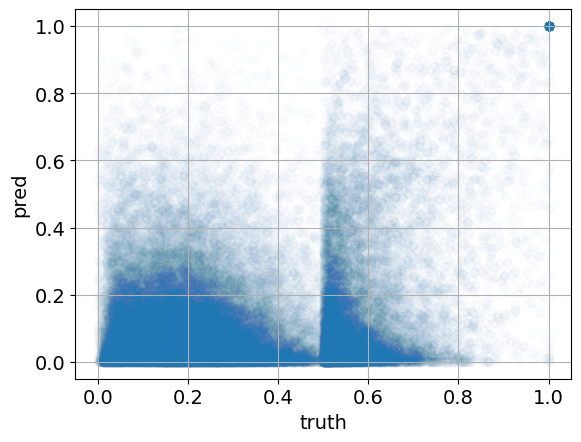

In [128]:
import matplotlib.pyplot as plt
plt.scatter(tanimoto_modcos, scores_modcos, alpha=0.01)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [129]:
tanimoto_modcos_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_modcos]
scores_modcos= [s if s>0 else 0 for s in scores_modcos ]

In [130]:
spearman_modcos = spearmanr(tanimoto_modcos, scores_modcos)

tpr: [0.00000000e+00 6.44745326e-04 1.61186331e-03 ... 9.91940683e-01
 9.91940683e-01 1.00000000e+00]
fpr: [0.         0.         0.         ... 0.98766554 0.98790458 1.        ]


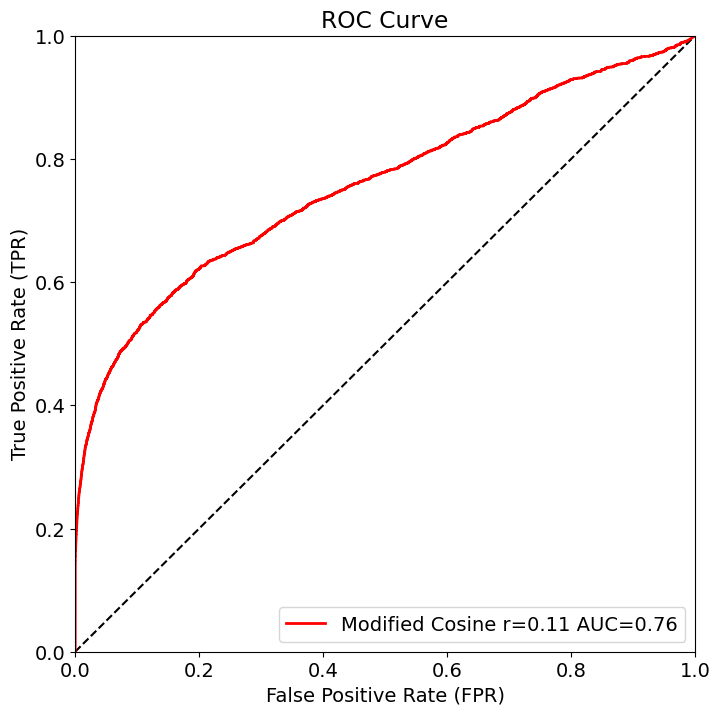

In [131]:
Plotting.plot_n_roc_curves(y_true_list= [tanimoto_modcos_binary, ],
                           y_scores_list=[scores_modcos, ],
                           labels=[ f'Modified Cosine r={spearman_modcos[0]:.2f}'],
                                   
                           colors = ['r','b','g', 'k'])
plt.grid()